In [11]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

from pymof import MOF

from sklearn.datasets import make_blobs
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NearestNeighbors

from scipy.spatial.distance import euclidean
from scipy.spatial.distance import cdist
from collections import defaultdict

import smote_variants as sv
from imblearn.over_sampling import BorderlineSMOTE

from collections import Counter

In [12]:
# Enter your Data set pathname
df_original = pd.read_csv(r'/Users/supakornsuksawat/Downloads/dataset for MSSG-SMOTE (clean&scaled)/Wilt dataset cleaned&scaled.csv')
data_name = 'Wilt'
df = df_original.copy()
# Select only numeric columns for normalization
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
scaler = MinMaxScaler()
label_encoder = LabelEncoder()

# Apply label encoding to each column that has non-numeric values
for column in df.columns:
    if df[column].dtype == 'object':  # Check if the column is non-numeric
        df[column] = label_encoder.fit_transform(df[column])

df = df.interpolate(axis=1) 

# Apply the scaler to the selected columns
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

col = df.columns.drop([df.columns[-1]])
target = df.columns[-1]

df_target = df[target]

In [13]:
df.head()

,GLCM_pan,Mean_Green,Mean_Red,Mean_NIR,SD_pan,target
0,0.656711,0.051669,0.087679,0.359168,0.132110,1.0
1,0.680591,0.048256,0.081768,0.291435,0.106749,1.0
2,0.734892,0.043814,0.083986,0.425844,0.143741,1.0
3,0.698087,0.017373,0.048350,0.208890,0.095697,1.0
4,0.738927,0.040925,0.077923,0.485794,0.112481,1.0


In [14]:
class MSSG :

    def __init__(self):
        pass

    def mof_scores(self, data):
        model = MOF()
        model.fit(data)
        scores = model.decision_scores_
        return scores

    def add_class(self ,data , y) :
        scores = self.mof_scores(data) 
        quartiles = np.quantile(scores , [0.25, 0.5, 0.75])

        add_class_dict = {
            i+1 :{"features" : data[i],
                  'MOF-Scores' : scores[i] ,
                  'target' : y[i] ,
                  'Class_quartiles' : ['Q1', 'Q2', 'Q3', 'Q4'][sum(scores[i] > q for q in quartiles)]} for i in range(data.shape[0])
        }
        return add_class_dict

    def sample(self , X,y):
        X_min = X[y == 1] 
        y_min = y[y == 1]
        
        X_maj = X[y == 0]

        all_dict = self.add_class(X,y)
        min_dict = self.add_class(X_min,y_min)

        synthetic_sample = X
        synthetic_target = y

        merged_dict = {}
        seen_features = set()

        for key1, value1 in all_dict.items():
            for key2, value2 in min_dict.items():
                if np.array_equal(value1["features"], value2["features"]):
                    features_tuple = tuple(value1["features"])
                    if features_tuple not in seen_features:  # Check for duplicates
                        merged_dict[key1] = {
                            "features": value1["features"],
                            "quartiles_minority": value2["Class_quartiles"],
                            "quartiles_all": value1["Class_quartiles"],
                            "target": value2["target"],
                        }
                        seen_features.add(features_tuple)

        #TODO Adjust ratio for synthetics instance
        quartiles_combinations = []
        for value in merged_dict.values():
            quartiles_combinations.append((value["quartiles_minority"] , value["quartiles_all"]))
        
        combination_counts = Counter(quartiles_combinations)

        #key[0] = minority class drop Q1 and Q2  and when minority class in Q4 and all in Q1 
        filtered_combinations = {key: value for key, value in combination_counts.items() if not (key[0] in ['Q1']) and not (key[0] == 'Q4' and key[1] == 'Q1')}

        nbrs = NearestNeighbors(n_neighbors=1).fit(X_maj) 
        distances, indices = nbrs.kneighbors(X_min)

        nbrs_class1 = NearestNeighbors(n_neighbors=2).fit(X_min)
        distances_class1 , indices_class1 = nbrs_class1.kneighbors(X_min)

        synthetic = []

        for i , (key, value) in enumerate(merged_dict.items()):

            if (value.get('quartiles_minority'), value.get('quartiles_all')) in filtered_combinations :
                
                ins = value.get('features')
                
                #Determine the number of synthetic samples per original point
                all_sample = round (len(X_maj) / len(filtered_combinations)) - filtered_combinations[(value.get('quartiles_minority'), value.get('quartiles_all'))]
                num_sample = round(all_sample / filtered_combinations[(value.get('quartiles_minority'), value.get('quartiles_all'))])
                                   
                nearest_min_ins = X_min[indices_class1[i][1]]

                for _ in range(num_sample):
                    if np.linalg.norm(nearest_min_ins - ins) == 0 :
                        alpha = 1
                    else :
                        ball_radius = distances.flatten()[i] / np.linalg.norm(nearest_min_ins - ins)
                        alpha = np.random.uniform(0, ball_radius)  # Random proportion along the line  

                    new_sample = ins + alpha*(nearest_min_ins - ins)
                    synthetic.append(new_sample)
            else :
                continue

        synthetic_sample = np.vstack((synthetic_sample , synthetic))
        synthetic_target = np.hstack((synthetic_target , [1]*len(synthetic)))
        
        return synthetic_sample , synthetic_target


In [15]:
X = df.iloc[:,:-1].to_numpy()
y = df[target].to_numpy()

X_ball , y_ball = MSSG().sample(X,y)

len X : 4339 and len X_synthetic : 8552


In [17]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


def K_fold(classification , X , y , smote_technique ):
	
	kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

	report_kfold = []
	Precision = []
	Recall = []
	F1 = []

	for fold , (train_ix, test_ix) in enumerate(kfold.split(X, y), 1):
		# select rows
		train_X, test_X = X[train_ix], X[test_ix]
		train_y, test_y = y[train_ix], y[test_ix]
		# summarize train and test composition
		train_0, train_1 = len(train_y[train_y==0]), len(train_y[train_y==1])
		test_0, test_1 = len(test_y[test_y==0]), len(test_y[test_y==1])

		
		# Apply Borderline-SMOTE using smote-variants
		if smote_technique == 'Original' : 
			X_train_resampled, y_train_resampled = train_X, train_y

		else :
			smote = smote_technique
			
			X_train_resampled, y_train_resampled = smote(train_X, train_y)

		model = classification

		model.fit(X_train_resampled, y_train_resampled)
		
		# Predictions
		y_pred = model.predict(test_X)

		report = classification_report(test_y, y_pred)
		
		# Calculate metrics
		Precision.append(precision_score(test_y, y_pred))
		Recall.append(recall_score(test_y, y_pred))
		F1.append(f1_score(test_y, y_pred))

	# Calculate mean of metrics
	mean_precision = np.mean(Precision)
	mean_recall = np.mean(Recall)
	mean_f1 = np.mean(F1)

	return mean_precision , mean_recall , mean_f1 

In [18]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Define classifiers
classifiers = {
    '(1)kNN': KNeighborsClassifier(n_neighbors=7 , p=2),
    '(2)Decision Tree': DecisionTreeClassifier(),
    '(3)Neural Network': MLPClassifier(hidden_layer_sizes=(16,16,2)  ,max_iter=2000 , activation= 'tanh'),
    '(4)SVM': SVC(kernel='rbf', gamma='scale'),
    '(5)Random Forest': RandomForestClassifier()
}

techniques = {
    '(1)Original': 'Original',
    '(2)SMOTE': sv.SMOTE().sample,
    '(3)Borderline':  BorderlineSMOTE(kind='borderline-1', random_state=42).fit_resample ,
    '(4)Safe-level': sv.Safe_Level_SMOTE().sample,
    '(5)MSSG': MSSG().sample,
}
kfold_result = []

for technique_name, smote in techniques.items():
    for clf_name, clf in classifiers.items():

        mean_precision , mean_recall , mean_f1 = K_fold( clf , X , y , smote)
        kfold_result.append({
            'Data Set' : data_name,
            'Class': 1,
            'Technique': technique_name,
            'Classifier' : clf_name ,
            'Precision' : mean_precision,
            'Recall' : mean_recall,
            'F1-score' : mean_f1,
        })

# Convert result_table to DataFrame
kfold_result_table = pd.DataFrame(kfold_result)

# Pivot the table to have techniques as columns, and the other metrics as rows
kfold_result_pivot = kfold_result_table.pivot_table(
    index=['Classifier', 'Class' , 'Data Set'],
    columns='Technique',
    values=['Precision', 'Recall', 'F1-score']
)

# Flatten the multi-level columns for better readability
kfold_result_pivot.columns = ['_'.join(col).strip() for col in kfold_result_pivot.columns.values]

# Reset index for final view
kfold_result_pivot.reset_index(inplace=True)


/Users/supakornsuksawat/Documents/Python Project Folder/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/supakornsuksawat/Documents/Python Project Folder/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/supakornsuksawat/Documents/Python Project Folder/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

In [19]:
kfold_result_pivot

,Classifier,Class,Data Set,F1-score_(1)Original,F1-score_(2)SMOTE,F1-score_(3)Borderline,F1-score_(4)Safe-level,F1-score_(5)MSSG,Precision_(1)Original,Precision_(2)SMOTE,Precision_(3)Borderline,Precision_(4)Safe-level,Precision_(5)MSSG,Recall_(1)Original,Recall_(2)SMOTE,Recall_(3)Borderline,Recall_(4)Safe-level,Recall_(5)MSSG
0,(1)kNN,1,Wilt,0.335191,0.498653,0.539550,0.372910,0.587293,1.000000,0.370889,0.437701,0.281660,0.506502,0.202857,0.785714,0.718095,0.583810,0.732381
1,(2)Decision Tree,1,Wilt,0.763305,0.759318,0.713835,0.559832,0.773796,0.774468,0.695801,0.666340,0.460378,0.761242,0.769524,0.837143,0.797143,0.717143,0.797143
2,(3)Neural Network,1,Wilt,0.000000,0.787385,0.763962,0.618432,0.772258,0.000000,0.679167,0.659698,0.450166,0.641653,0.000000,0.959048,0.945714,1.000000,0.985714
3,(4)SVM,1,Wilt,0.000000,0.555782,0.647242,0.569024,0.510245,0.000000,0.394438,0.490169,0.405222,0.348641,0.000000,0.986667,0.986667,0.986667,1.000000
4,(5)Random Forest,1,Wilt,0.720249,0.812344,0.775762,0.750348,0.778021,0.959596,0.828587,0.866651,0.830220,0.826703,0.580952,0.810476,0.717143,0.689524,0.742857


In [21]:
f1_result = kfold_result_pivot.iloc[:,0:8]

# Add column for the max F1-score
f1_columns = [
    "F1-score_(1)Original",
    "F1-score_(2)SMOTE",
    "F1-score_(3)Borderline",
    "F1-score_(4)Safe-level",
    "F1-score_(5)MSSG",
]
f1_result["Max_F1_score"] = f1_result[f1_columns].idxmax(axis=1)

f1_result

,Classifier,Class,Data Set,F1-score_(1)Original,F1-score_(2)SMOTE,F1-score_(3)Borderline,F1-score_(4)Safe-level,F1-score_(5)MSSG,Max_F1_score
0,(1)kNN,1,Wilt,0.335191,0.498653,0.539550,0.372910,0.587293,F1-score_(5)MSSG
1,(2)Decision Tree,1,Wilt,0.763305,0.759318,0.713835,0.559832,0.773796,F1-score_(5)MSSG
2,(3)Neural Network,1,Wilt,0.000000,0.787385,0.763962,0.618432,0.772258,F1-score_(2)SMOTE
3,(4)SVM,1,Wilt,0.000000,0.555782,0.647242,0.569024,0.510245,F1-score_(3)Borderline
4,(5)Random Forest,1,Wilt,0.720249,0.812344,0.775762,0.750348,0.778021,F1-score_(2)SMOTE


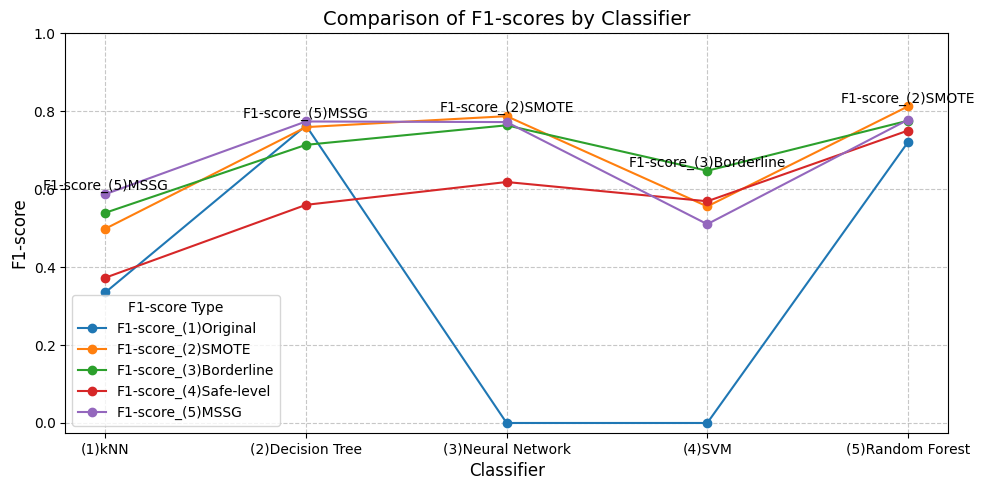

In [26]:
# Define the F1-score columns
f1_columns = [
    "F1-score_(1)Original",
    "F1-score_(2)SMOTE",
    "F1-score_(3)Borderline",
    "F1-score_(4)Safe-level",
    "F1-score_(5)MSSG",
]

plt.figure(figsize=(10, 5))
# Plot lines for each F1-score type
for col in f1_columns:
    plt.plot(f1_result["Classifier"], f1_result[col], marker='o', label=col)

# Annotate the highest F1-score column above each data point
for i in range(len(f1_result)):
    max_col = f1_result["Max_F1_score"].iloc[i]
    max_value = f1_result[max_col].iloc[i]
    classifier = f1_result["Classifier"].iloc[i]
    plt.text(classifier, max_value + 0.01, max_col, fontsize=10, ha='center')

# Add labels, title, and legend
plt.xlabel("Classifier", fontsize=12)
plt.ylabel("F1-score", fontsize=12)
plt.title("Comparison of F1-scores by Classifier", fontsize=14)
plt.xticks(rotation=0, fontsize=10)
plt.legend(title="F1-score Type", fontsize=10)
plt.ylim(f1_result[f1_columns].min(axis=1).min() - 0.025 ,1)
plt.grid( linestyle="--", alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()
